In [1]:
%matplotlib inline

import ephem

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import blackman
from scipy.io import wavfile
import scipy.signal

from multiprocessing import Pool

import functools

# Larger figure size
fig_size = [14, 8]
plt.rcParams['figure.figsize'] = fig_size

c = 299792458

line1 = "FO-29"
line2 = "1 24278U 96046B   17296.90226955 -.00000046 +00000-0 -99197-5 0  9993"
line3 = "2 24278 098.5410 162.9058 0350559 003.9820 356.3983 13.53079989046036"

sat = ephem.readtle(line1, line2, line3)

ea4gpz_qth = ephem.Observer()
ea4gpz_qth.lat, ea4gpz_qth.lon, ea4gpz_qth.elevation = '40.5962', '-3.6963', 700

start = ephem.Date('2017/10/23 20:26:00')
t_step = 1e-2
ts = np.arange(0, 990, t_step)

ft8_freq_down = -35700
beacon_freq = -51410
f_down = 435.850e6
f_up = 145.990e6

def computeDoppler(tles, freq, delay = 0.0, qth = ea4gpz_qth):
    dopplers = np.empty_like(ts)
    for j in range(len(ts)):
        qth.date = start + ts[j]*ephem.second - delay*ephem.second
        tles.compute(qth)
        dopplers[j] =  -tles.range_velocity/c*freq
    return dopplers

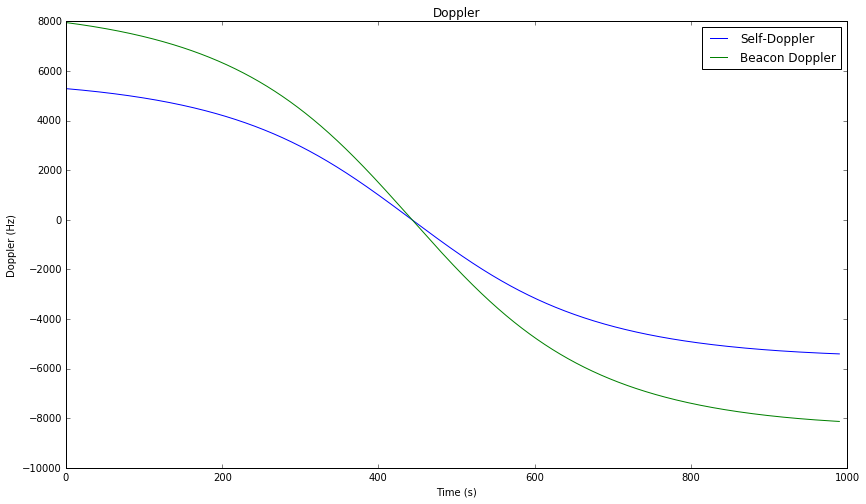

In [2]:
self_doppler = computeDoppler(sat, f_down + ft8_freq_down - f_up)
beacon_doppler = computeDoppler(sat, f_down + beacon_freq)

plt.plot(ts, self_doppler)
plt.plot(ts, beacon_doppler)
plt.title('Doppler')
plt.xlabel('Time (s)')
plt.ylabel('Doppler (Hz)')
plt.legend(['Self-Doppler', 'Beacon Doppler']);

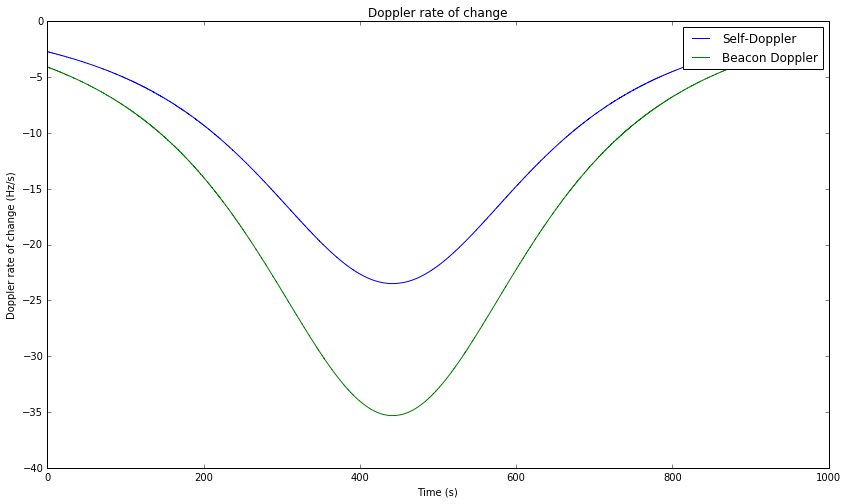

In [3]:
plt.plot(ts, (computeDoppler(sat, f_down + ft8_freq_down - f_up) - computeDoppler(sat, f_down + ft8_freq_down - f_up, delay=0.1))*10)
plt.plot(ts, (computeDoppler(sat, f_down + beacon_freq) - computeDoppler(sat, f_down + beacon_freq, delay=0.1))*10)
plt.title('Doppler rate of change')
plt.xlabel('Time (s)')
plt.ylabel('Doppler rate of change (Hz/s)')
plt.legend(['Self-Doppler', 'Beacon Doppler']);

In [4]:
wav_iq = np.memmap('/home/daniel/fo29ft8.wav', dtype=np.int16, mode='r', offset=0x28)
samp_rate = 192000

In [5]:
def oscillator(doppler, length, signal_start = 0):
    phase = 0.0
    x = np.empty(length, dtype=np.complex)
    for j in range(length):
        index = int((signal_start + j/samp_rate)/t_step)
        freq = -doppler[index]
        phase += 2*np.pi*freq/samp_rate
        phase = np.fmod(phase + np.pi, 2*np.pi) - np.pi
        x[j] = np.exp(1j*phase)
    return x

In [6]:
# Doppler correct and save to file

period_len = 15

start_hour = 20
start_min = 26
start_sec = 0
start_seconds = 3600 * start_hour + 60 * start_min + start_sec

num_periods = len(wav_iq)//2//samp_rate//period_len

wsjtx_samp_rate = 12000

def process_period(period, centre_freq, output_dir, doppler, drift=0):
    #print('Computing period {}'.format(period))
    offset = samp_rate * period * period_len * 2
    length = samp_rate * period_len * 2
    period_samples = wav_iq[offset:offset+length]
    period_iq = period_samples[::2] + 1j*period_samples[1::2]
    
    doppler_oscillator = oscillator(doppler, len(period_iq), signal_start=period*period_len)
    
    freq_offset = 1500
    
    period_mixed = period_iq * doppler_oscillator * np.exp(1j*2*np.pi*(np.arange(len(period_iq))*(freq_offset - centre_freq)/samp_rate - 0.5*np.arange(period*len(period_iq), (period+1)*len(period_iq))**2*drift/samp_rate**2))
    period_decim = scipy.signal.decimate(period_mixed, 192//48)
    half = len(period_decim)//2
    other_half = len(period_decim) - half
    real_48 = np.real(np.fft.ifft(np.fft.fft(period_decim) * np.concatenate((np.ones(half), np.zeros(other_half)))))
    real_12 = scipy.signal.decimate(real_48, 48//12)
    scaling = 16
    
    period_seconds = start_seconds + period * period_len
    filename = '{}/171023_{:02d}{:02d}{:02d}.wav'.format(output_dir, period_seconds // 3600, (period_seconds // 60) % 60, period_seconds % 60)
    wavfile.write(filename, wsjtx_samp_rate, (scaling*real_12).astype(np.int16))

    return real_12

In [7]:
def compute(centre_freq, output_dir, doppler, drift = 0):
    with Pool() as pool:
        process = functools.partial(process_period, centre_freq = centre_freq, output_dir = output_dir, doppler = doppler, drift = drift)
        return np.array(pool.map(process, range(num_periods)))

In [8]:
ft8_corrected = compute(ft8_freq_down, 'fo29/ft8', self_doppler)

In [9]:
beacon_corrected = compute(beacon_freq, 'fo29/beacon', beacon_doppler)

In [10]:
N_waterfall = 6000
avg_waterfall = 6

def plot_waterfall(samples, bins, fit_slope, fit_start, fit_end):
    N = N_waterfall
    avg = avg_waterfall
    l = samples.size // N
    w = blackman(N)
    spectrum = np.abs(np.fft.rfft(samples.reshape((l,N))*w))**2
    avg_spectrum = 10*np.log10(np.array([np.average(spectrum[j:j+avg, ...], axis=0) for j in range(0,spectrum.shape[0],avg)]))
    plt.imshow(avg_spectrum[:,bins], vmin = 35, vmax = 65, cmap='viridis', aspect = 0.05*avg);
    t = np.linspace(fit_start,fit_end)
    plt.plot(t,(t-fit_start)/fit_slope, 'r')
    
def compute_drift(fit_slope):
    return fit_slope * (wsjtx_samp_rate / N_waterfall)**2 / avg_waterfall

0.1111111111111111

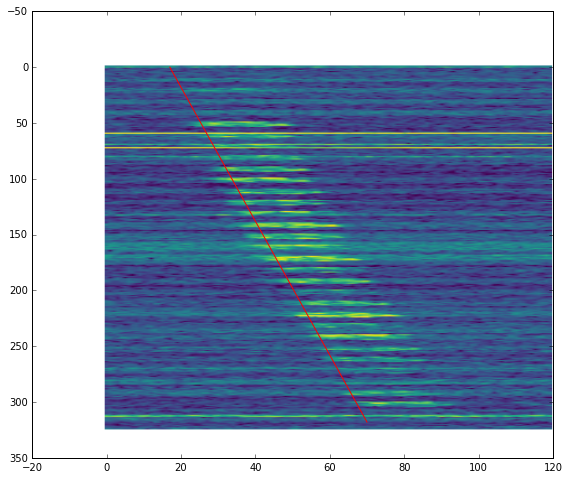

In [11]:
slope = 1/6
plot_waterfall(ft8_corrected, np.arange(680,800), slope, 17, 70)
ft8_drift = compute_drift(slope)
ft8_drift

0.08547008547008546

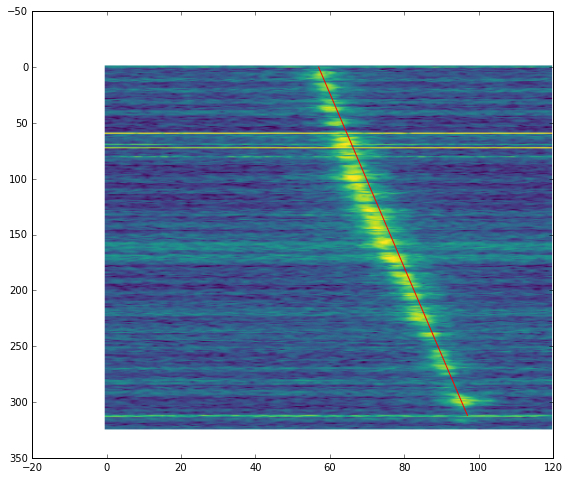

In [12]:
slope = 5/39
plot_waterfall(beacon_corrected, np.arange(680,800), slope, 57, 97)
beacon_drift = compute_drift(slope)
beacon_drift

In [13]:
1-(ft8_drift/beacon_drift)/((f_down + f_up)/f_down)

0.026184174343462097

In [14]:
ft8_nodrift = compute(ft8_freq_down, 'fo29/ft8_nodrift', self_doppler, ft8_drift)

In [15]:
beacon_nodrift = compute(beacon_freq, 'fo29/beacon_nodrift', beacon_doppler, beacon_drift)

In [16]:
def energy_spectral_density(x):
    N = 12000
    l = x.size // N
    return np.sum(np.abs(np.fft.rfft(x.reshape((l,N))))**2, axis=0)

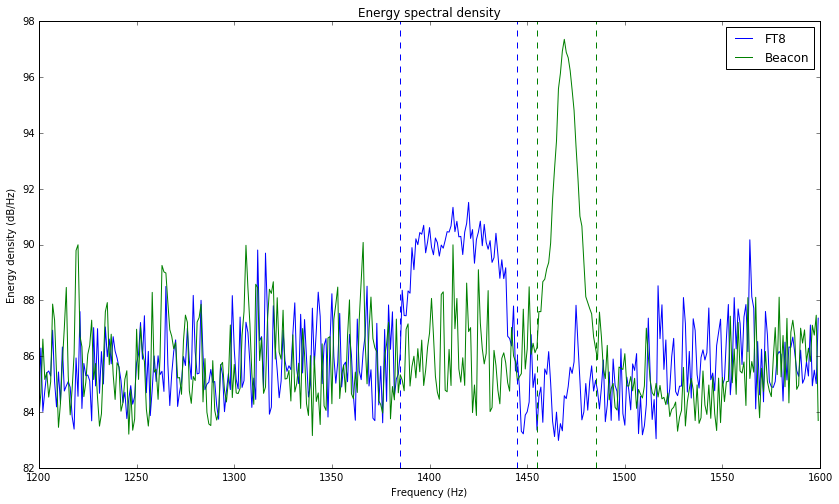

In [17]:
bins = np.arange(1200, 1600)
ft8_energy_density = energy_spectral_density(ft8_nodrift)[bins]
beacon_energy_density = energy_spectral_density(beacon_nodrift)[bins]
x = np.fft.rfftfreq(12000)[bins]*wsjtx_samp_rate
plt.plot(x, 10*np.log10(ft8_energy_density))
plt.plot(x,10*np.log10(beacon_energy_density),'g')
ft8_start = 185
ft8_end = 245
plt.axvline(x=x[ft8_start], linestyle='--')
plt.axvline(x=x[ft8_end], linestyle='--')
beacon_start = 255
beacon_end = 285
plt.axvline(x=x[beacon_start], color='g', linestyle='--')
plt.axvline(x=x[beacon_end], color='g', linestyle='--')
plt.title('Energy spectral density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy density (dB/Hz)')
plt.legend(['FT8', 'Beacon']);

In [18]:
ft8_energy = 10*np.log10(np.sum(ft8_energy_density[ft8_start:ft8_end]))
ft8_energy

107.52158656254629

In [19]:
beacon_energy = 10*np.log10(np.sum(beacon_energy_density[beacon_start:beacon_end]))
beacon_energy

107.78701937955832